In [1]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import os
from torchvision import transforms
import torchvision
import torch.optim as optim
import numpy as np
!pip install pytorch_metric_learning
import PIL
import torch.nn.functional as F
from torchsummary import summary

In [2]:
# ##download dataset 
# ##밑에 코드 주석을 풀면 cub.zip 파일이 다운받아지고 cub라는 폴더가 생깁니다. 
# ! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1o0grxoqCxcrgI6Nd4nxybXulU5IrE8wX' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1o0grxoqCxcrgI6Nd4nxybXulU5IrE8wX" -O CUB.zip && rm -rf /tmp/cookies.txt
# ! unzip CUB.zip 
# ! mkdir CUB
# ! mv train ./CUB

In [3]:
# ./cub/train
## class 1
    ## class1_1.jpg
    ## class1_2.jpg
    ## class1_3.jpg
## class 2

## class 200

image_folder = torchvision.datasets.ImageFolder(root = "./CUB/train")
len(image_folder.imgs)
image_folder.imgs[100]

('./CUB/train/002.Laysan_Albatross/Laysan_Albatross_0071_792.jpg', 1)

In [4]:
class CUBirds(Dataset):
    def __init__(self, root, mode, transform = None): #root: "./"
        ## implement
        self.root = root
        self.mode = mode # class 0 - 99: train, 100 - 199: eval
        self.transform = transform
        
        if self.mode == "train":
            self.classes = range(0, 100)
        elif self.mode == "eval":
            self.classes = range(100, 200)
        else:
            raise NotImplementedError 
        
        # imagefolder 함수를 통해 image path, label가져오기. 
        # imagefolder.imgs를 통해 모든 이미지에 대한 정보 접근 가능.
        ## image path, label = []
        self.ys, self.im_paths = [], []
        
        image_folder = torchvision.datasets.ImageFolder(root = self.root)
        
        for img in image_folder.imgs: # imgs list
            # img: tuple, [0]: image path [1]: label
            y = img[1]
            
            if y in self.classes:
                self.ys += [y]
                self.im_paths.append(img[0])
            
    def __getitem__(self, index):
        ## implement
        img = PIL.Image.open(self.im_paths[index]).convert("RGB")
        img = self.transform(img)
        
        target = self.ys[index]
        
        return img, target
    
    def __len__(self):
        ## implement
        return len(self.ys)

In [5]:
transform = torchvision.transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), #0.5, 0.5 
        transforms.Resize((224, 224))
    ])

##define dataset
train_dataset = CUBirds("./CUB/train", mode = "train", transform = transform)
val_dataset = CUBirds("./CUB/train", mode = "eval", transform = transform)
print(len(train_dataset))
print(len(val_dataset))

## concat two dataset
## 나중에 전체 데이터를 대상으로 retrieval 하기 위함
full_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
print(len(full_dataset))

# define loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64)
full_loader = torch.utils.data.DataLoader(full_dataset, batch_size=64)

5866
5924
11790


In [6]:
resnet = torchvision.models.resnet18()
print(resnet.fc.in_features)

512


In [7]:
## load pretrained resnet18 from torchvision.models
## replace the last fc layer to map it to embedding space
class Resnet18(nn.Module):
    def __init__(self, embedding_size, pretrained=True): # embedding_size 500
        super(Resnet18, self).__init__()
        ## implement
        self.model = torchvision.models.resnet18(pretrained = pretrained)
        
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, embedding_size)

    def forward(self, x):
        ## implement
        x = self.model(x)
        
        return x

In [8]:
#define model
device = "cuda:0"
model = Resnet18(500, True) 
summary(model, batch_size=-1, input_size=(3, 224, 224), device='cpu')
model = model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [9]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0, num_classes = 200):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.num_classes = num_classes

    def forward(self, output, labels): ##output shape: [batch, embedding_size], labels shape: [Batch,]
        ## implement 
        ## output: [batch, 500], labels: [500]
        batch = output.shape[0] # batch
        
        index_matrix = np.zeros([self.num_classes, batch]) ## label list dictionary # cls * batch
        labels = labels.detach().cpu().numpy() 

        for c in range(self.num_classes):
            indices = np.where(labels == c) # return idx where labels == c
            index_matrix[c, indices] = 1
        # Cls * batch # 200 * 64
        
        index_matrix = torch.tensor(index_matrix).cuda() # 200 *64
        label_matrix = index_matrix[labels] # 64 * 64
        
        ##label _matrix
        ## compute distance dist(i,j)
        ## output들의 pairwise distance를 계산
        euclidean_distance = torch.cdist(output, output, p = 2) # [batch, batch]
        
        ## define loss
        loss_contrastive = torch.mean(label_matrix * euclidean_distance + (1-label_matrix) * torch.clamp(self.margin - euclidean_distance, min = 0.0))
        
        return loss_contrastive

In [21]:
class ContrastiveLoss_easy(torch.nn.Module):
    def __init__(self, margin=2.0, num_classes = 200):
        super(ContrastiveLoss_easy, self).__init__()
        self.margin = margin
        self.num_classes = num_classes

    def forward(self, output, labels): ##output shape: [batch, embedding_size], labels shape: [Batch,]
        ## output: [batch, 500], labels: [batch]
        ## implement
        
        ##compute label matrix y_ij
        label_matrix = []
        for i in labels: # labels: [1, 1, 2, 3]
            ys = []
            for j in labels:
                if i == j: #같을때
                    ys.append(1)
                else: #다를때
                    ys.append(0)
            label_matrix.append(ys)
        ## label_matrix: shape -> [batch, batch]
        label_matrix = torch.tensor(label_matrix).cuda()
        
        ## compute distance dist(i,j)
        ## output들의 pairwise distance를 계산
        euclidean_distance = torch.cdist(output, output, p = 2) # [batch, batch]
        
        ## define loss
        loss_contrastive = torch.mean(label_matrix * euclidean_distance + (1-label_matrix) * torch.clamp(self.margin - euclidean_distance, min = 0.0))
        
        return loss_contrastive

In [22]:
##metric learning losses are defined in pytorch_metric_learning package
## many losses are defined in pytorch_metric_learning! try to use other lossses 
# https://github.com/KevinMusgrave/pytorch-metric-learning/tree/master/src/pytorch_metric_learning/losses
## criterion = losses.ContrastiveLoss(neg_margin = 0.5) contrastive loss from pytorch github

from pytorch_metric_learning import miners, losses

#define optimizer, criterion
optimizer = optim.Adam(model.parameters(), lr=1e-5) 

## implement criterion
# criterion = ContrastiveLoss_easy(margin = 2.0)
criterion = losses.ContrastiveLoss(neg_margin = 0.5)

In [23]:
EPOCHS = 5

# Training Loop
for epoch in (range(EPOCHS)):
    running_loss = 0.
    model.train()
    for batch_idx, batch in enumerate(train_loader):
        data, target = batch
        data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        
        output = model(data) ## [batch, 500]
        
        loss = criterion(output,  target.squeeze()) ## loss forward 
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    train_loss = running_loss/len(train_loader)
    
    print(f"Epochs = {epoch}, Training Loss : {train_loss}")
    
    ##validation
    valid_loss = 0.
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            data, target = batch
            data, target = data.cuda(), target.cuda()
            
            output = model(data)
        
            loss = criterion(output, target.squeeze())
            valid_loss += loss.item()
            
    val_loss = valid_loss/len(val_loader)

    print(f"Epochs = {epoch}, Validation Loss : {val_loss}")

Epochs = 0, Training Loss : 0.04523951003489935
Epochs = 0, Validation Loss : 2.206196270963197


KeyboardInterrupt: 

In [15]:
## 전체 dataset에 대한 feature vector (embedding)을 구함
def create_embedding(model, full_loader, device):
    ## implement
    ## to do: run iteration over full_loader, save each embeddings
    model.eval()
    model = model.to(device)
    embeddings = torch.tensor([])
    
    with torch.no_grad():
        for idx, data in enumerate(full_loader):
            img, ibl = data
            img, ibl = img.to(device), ibl.to(device)
            
            output = model(img).cpu() # [batch, 500]
            embeddings = torch.cat((embeddings, output), 0) #batch
            
    # Return the embeddings
    return embeddings

In [18]:
## image와 가장 비슷한 top k개 image의 idx를 뽑음
from sklearn.neighbors import NearestNeighbors

def compute_similar_images(image, num_images, embedding, device):
    ## image: pil image 
    ## num_images: top k
    ## embedding: [11790, 500]
    transform = torchvision.transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), 
        transforms.Resize((224, 224))
    ])
    ## implement
    ## hint: image -> model forward : feature 500
    ## feature_500, embedding 간의 비교: KNN 
    ## use sklearn: nearestneighbor to compute k nearest neighbor 
    image_tensor = transform(image).to(device) # pil image -> tensor # [3, 224, 224]
    image_tensor = image_tensor.unsqueeze(0) #[1, 3, 224, 224]
    
    with torch.no_grad():
        image_embedding = model(image_tensor).cpu().detach().numpy() # [1, 500]
    
    flattened_embedding = image_embedding.reshape((image_embedding.shape[0], -1)) # [1, 500]
    
    ## k nearest neighbor
    knn = NearestNeighbors(n_neighbors = num_images, metric = "cosine")
    knn.fit(embedding.reshape((embedding.shape[0], -1)))
    k_embeddings, indices = knn.kneighbors(flattened_embedding)
    indices_list = indices.tolist()
    return indices_list # knn top k index

In [16]:
#get embedding of images from full_loader
embedding = create_embedding(model, full_loader, device)

In [17]:
embedding.shape ## [11790, 500] 

torch.Size([11790, 500])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[9123, 2319, 5985, 2438, 10047, 799, 9568, 6092, 7989, 4489, 4495, 2072, 5966, 9149, 5111, 4469, 2239, 9134, 2234, 3874]]


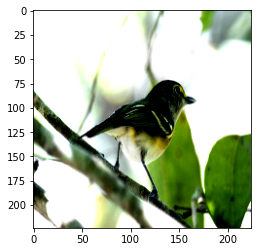

> <ipython-input-20-185b980c1219>(15)<module>()
     13 print(indices_list)
     14 
---> 15 for i in indices_list[0]:
     16     img, _ = full_dataset[i]
     17     imshow(img)



ipdb>  c


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


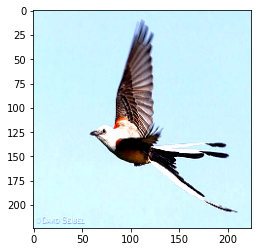

> <ipython-input-20-185b980c1219>(15)<module>()
     13 print(indices_list)
     14 
---> 15 for i in indices_list[0]:
     16     img, _ = full_dataset[i]
     17     imshow(img)



ipdb>  c


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


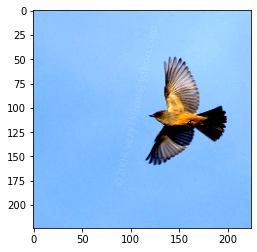

> <ipython-input-20-185b980c1219>(15)<module>()
     13 print(indices_list)
     14 
---> 15 for i in indices_list[0]:
     16     img, _ = full_dataset[i]
     17     imshow(img)



ipdb>  c


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


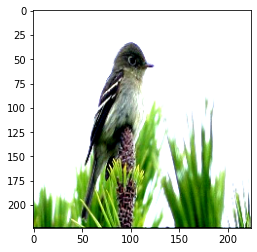

> <ipython-input-20-185b980c1219>(15)<module>()
     13 print(indices_list)
     14 
---> 15 for i in indices_list[0]:
     16     img, _ = full_dataset[i]
     17     imshow(img)



ipdb>  c


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


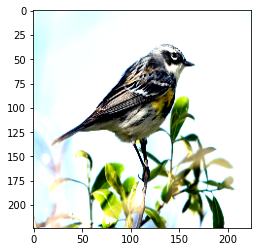

> <ipython-input-20-185b980c1219>(15)<module>()
     13 print(indices_list)
     14 
---> 15 for i in indices_list[0]:
     16     img, _ = full_dataset[i]
     17     imshow(img)



ipdb>  c


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


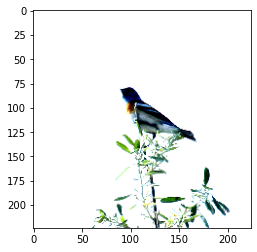

> <ipython-input-20-185b980c1219>(15)<module>()
     13 print(indices_list)
     14 
---> 15 for i in indices_list[0]:
     16     img, _ = full_dataset[i]
     17     imshow(img)



ipdb>  c


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


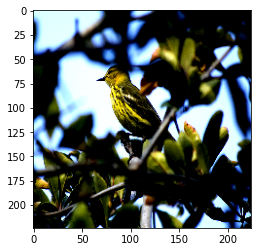

> <ipython-input-20-185b980c1219>(15)<module>()
     13 print(indices_list)
     14 
---> 15 for i in indices_list[0]:
     16     img, _ = full_dataset[i]
     17     imshow(img)



ipdb>  c


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


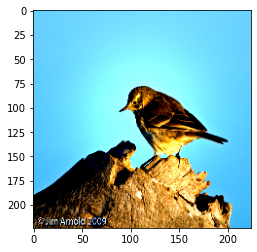

> <ipython-input-20-185b980c1219>(15)<module>()
     13 print(indices_list)
     14 
---> 15 for i in indices_list[0]:
     16     img, _ = full_dataset[i]
     17     imshow(img)



ipdb>  c


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


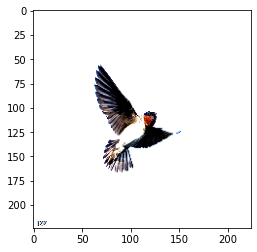

> <ipython-input-20-185b980c1219>(15)<module>()
     13 print(indices_list)
     14 
---> 15 for i in indices_list[0]:
     16     img, _ = full_dataset[i]
     17     imshow(img)



ipdb>  q


BdbQuit: 

In [20]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
import matplotlib.pyplot as plt
import PIL

##find the most closest image to input_image in the full_dataset
input_image = PIL.Image.open("bird_new.jpg").convert("RGB")
indices_list = compute_similar_images(input_image, 20, embedding, device)
print(indices_list)

for i in indices_list[0]:
    img, _ = full_dataset[i]
    imshow(img)
    import pdb; pdb.set_trace()